# Modelos lineales

Este notebook se enfoca en la implementación de modelos lineales (tanto de regresión como de clasificación) usando una vectorización estándar _Bag_of_Words_ (BoW).

In [1]:
import sys
sys.path.insert(0, '..')
from utils.preprocesamiento import StemmerTokenizer, df_to_list, process_df, procesar_adela
from utils.cargar import df_caso
import pandas as pd

tokenizador = StemmerTokenizer(stem=False,rmv_punctuation=True,)

caso = 'adela'
df = df_caso(caso)
df = procesar_adela(df)
df = df[df['opt_left'] == 'Producir el alimento contra déficit vitamínico']
df = process_df(df,'comment','sel',verbose=False)
df = df.drop(columns=['user_id','team_id','gender','df','title','opt_left','opt_right','max_num','phase','time','curso'])

train_indices = pd.read_csv('../utils/splits/train_indices_{}'.format(caso), header=None)[0].tolist()
test_indices = pd.read_csv('../utils/splits/test_indices_{}'.format(caso), header=None)[0].tolist()
print("Partición train-test cargada")

df_train = df.iloc[train_indices]
df_test = df.iloc[test_indices]

tokenized_corpus = [tokenizador(document) for document in df_train['comment']]
tokenized_test = [tokenizador(document) for document in df_test['comment']]

Partición train-test cargada


## Regresión con vectorizador Bag-of-Words

In [2]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from utils.preprocesamiento import make_BoW_preprocess, StemmerTokenizer

In [3]:
tokenizer = StemmerTokenizer(stem=False,rmv_punctuation=True,)
# preprocessing = make_BoW_preprocess(tokenizador,'comment',max_ngram=2,min_ngram=1,mindf=1)

bog_pipeline = Pipeline(
    [("Preprocessing", make_BoW_preprocess(tokenizador,'comment',max_ngram=2,min_ngram=1,mindf=1)),
    #  ("Selection", SelectPercentile(f_classif, percentile=90)),
    ("Clasificador", Ridge())]
)

Búsqueda de grilla para mejores parámetros

In [4]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

grid = [{
        "Clasificador": [Ridge()],
        "Clasificador__alpha":[0,0.5,1,5],
        "Preprocessing__bag-of-words__ngram_range":[(1,1), (1,2), (1,3)],
        "Preprocessing__bag-of-words__min_df": [0,2,5,10,20],
    }]

hgs = HalvingGridSearchCV(bog_pipeline, grid, n_jobs=-1, scoring='r2', verbose=0)    

In [5]:
%%capture
hgs.fit(df_train,df_train['sel'])

/home/camilo/miniconda3/envs/ethics_env/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/camilo/miniconda3/envs/ethics_env/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/camilo/miniconda3/envs/ethics_env/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/camilo/miniconda3/envs/ethics_env/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/camilo/miniconda3/envs/ethics_env/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter '

In [6]:
hgs.best_params_ 

{'Clasificador': Ridge(alpha=5),
 'Clasificador__alpha': 5,
 'Preprocessing__bag-of-words__min_df': 0,
 'Preprocessing__bag-of-words__ngram_range': (1, 3)}

Re-entrenamos el clasificador con los parámetros encontrados por temas de compatibilidad con la sección de tokens importantes.

In [7]:
alpha_hgs = hgs.best_params_['Clasificador'].alpha
mindf_hgs = hgs.best_params_['Preprocessing__bag-of-words__min_df']
min_ngram_hgs, max_ngram_hgs = hgs.best_params_['Preprocessing__bag-of-words__ngram_range']

bog_pipeline = Pipeline(
    [("Preprocessing", make_BoW_preprocess(tokenizador,'comment',max_ngram=max_ngram_hgs,min_ngram=min_ngram_hgs,mindf=mindf_hgs)),
    ("Clasificador", Ridge(alpha=alpha_hgs))]
)

bog_pipeline.fit(df_train,df_train['sel'])

/home/camilo/miniconda3/envs/ethics_env/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('Preprocessing',
                 ColumnTransformer(transformers=[('bag-of-words',
                                                  CountVectorizer(min_df=0,
                                                                  ngram_range=(1,
                                                                               3),
                                                                  tokenizer=<utils.preprocesamiento.StemmerTokenizer object at 0x7fa368509070>),
                                                  'comment')])),
                ('Clasificador', Ridge(alpha=5))])

**Evaluación**: sometemos el regresor a una evaluación de clasificador para poder comparar los métodos (la inversa también será implementada: evaluar un clasificador como un regresor).

In [8]:
import numpy as np

def reg_to_clf_output(reg_output):
    clf_output = np.round(reg_output).astype(int)
    clf_output = np.where(clf_output < 1, 1, clf_output)
    clf_output = np.where(clf_output > 6, 6, clf_output)
    return clf_output

In [9]:
from sklearn.metrics import classification_report

y_pred = bog_pipeline.predict(df_test)
clf_y_pred = reg_to_clf_output(y_pred)

print("Resultados modelo Regresión lineal (BoW) como clasificador")
print(classification_report(df_test['sel'], clf_y_pred))

Resultados modelo Regresión lineal (BoW) como clasificador
              precision    recall  f1-score   support

           1       0.58      0.26      0.36       125
           2       0.48      0.44      0.46       292
           3       0.42      0.61      0.50       347
           4       0.39      0.47      0.43       205
           5       0.45      0.22      0.29       139
           6       0.58      0.15      0.24        46

    accuracy                           0.44      1154
   macro avg       0.48      0.36      0.38      1154
weighted avg       0.46      0.44      0.43      1154



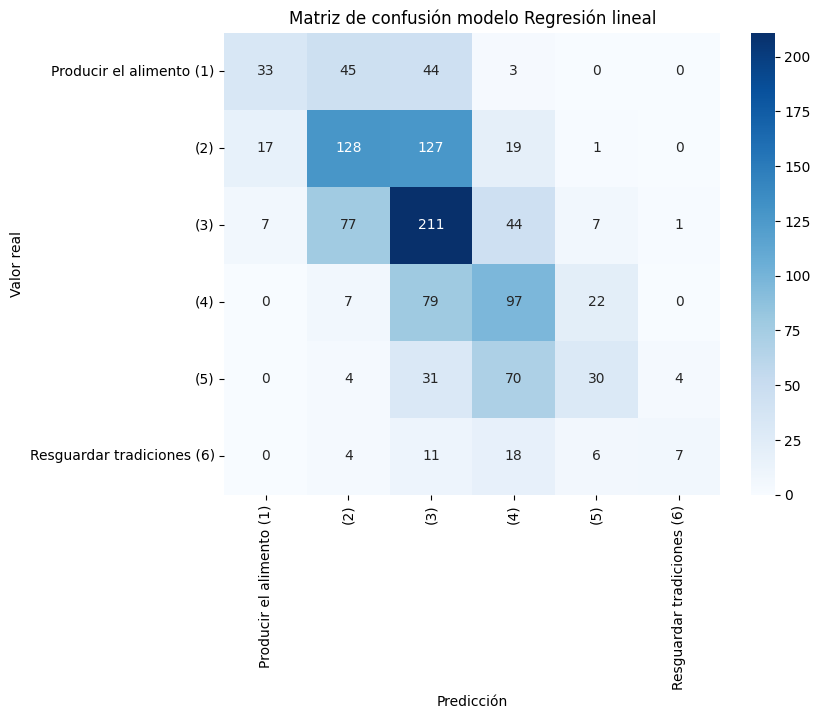

In [10]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(df_test['sel'], clf_y_pred)

# Example class labels
class_labels = ['Producir el alimento (1)', '(2)', '(3)', '(4)', '(5)', 'Resguardar tradiciones (6)']

# Convert confusion matrix to NumPy array
cm_array = np.array(cm)

# Create a heatmap using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_array, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)

# Set labels and title
plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.title('Matriz de confusión modelo Regresión lineal')

# Show the plot
plt.show()

In [11]:
df_bin = df.copy()

df_bin.loc[(df_bin['sel']==2) | (df_bin['sel']==3),'sel'] = 1
df_bin.loc[(df_bin['sel']==4) | (df_bin['sel']==5),'sel'] = 6

# df_train_bin = df_bin.iloc[train_indices]
df_test_bin = df_bin.iloc[test_indices]

In [12]:
clf_y_pred = np.where(clf_y_pred > 3.5, 6, clf_y_pred)
clf_y_pred = np.where(clf_y_pred < 3.5, 1, clf_y_pred)

print("Resultados modelo Regresión lineal como clasificación binaria")
print(classification_report(df_test_bin['sel'], clf_y_pred))

Resultados modelo Regresión lineal como clasificación binaria
              precision    recall  f1-score   support

           1       0.84      0.90      0.87       764
           6       0.77      0.65      0.71       390

    accuracy                           0.82      1154
   macro avg       0.80      0.78      0.79      1154
weighted avg       0.81      0.82      0.81      1154



Resultados similares a Naive-Bayes

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Evaluate the regressor using different metrics
mae = mean_absolute_error(df_test['sel'], y_pred)
mse = mean_squared_error(df_test['sel'], y_pred)
rmse = mean_squared_error(df_test['sel'], y_pred, squared=False)  # Calculate RMSE (set squared=False)
r2 = r2_score(df_test['sel'], y_pred)

# Print the evaluation metrics
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared (R2) Score:", r2)

Mean Absolute Error: 0.7725494082374482
Mean Squared Error: 1.0467722110166586
Root Mean Squared Error: 1.0231188645590787
R-squared (R2) Score: 0.3841863031844823


### Interpretabilidad: buscando tokens significativos

In [36]:
# Get the coefficients and feature names
coefficients = bog_pipeline['Clasificador'].coef_
vectorizer = bog_pipeline.named_steps['Preprocessing'].transformers_[0][1]
feature_names = vectorizer.get_feature_names_out()

# Create a list of (feature name, coefficient) pairs
feature_coefficient_pairs = list(zip(feature_names, coefficients))

# Sort the pairs by the absolute value of the coefficient in descending order
sorted_feature_coefficient_pairs = sorted(feature_coefficient_pairs, key=lambda x: abs(x[1]), reverse=True)

# Extract the most important tokens (e.g., top 10)
top_tokens = [pair[0] for pair in sorted_feature_coefficient_pairs[:10]]

# Print the top tokens and their coefficients
for token, coefficient in sorted_feature_coefficient_pairs[:10]:
    print(f"Token: {token}, Coefficient: {coefficient}")

Token: decision, Coefficient: 0.43715496966362155
Token: tradiciones vital, Coefficient: -0.414310994964939
Token: salud, Coefficient: -0.41228652361170826
Token: mantengo opinión, Coefficient: 0.4105101507406074
Token: hoy soluciones, Coefficient: 0.3901931500974141
Token: priorizar tradiciones, Coefficient: 0.38475554126574735
Token: decision grupal, Coefficient: 0.3686807546752324
Token: sigo misma opinion, Coefficient: 0.36350975527826385
Token: respetar, Coefficient: 0.3607252304268249
Token: soluciones, Coefficient: 0.3584465743822969


In [37]:
bog_pipeline['Clasificador'].intercept_

3.0687591038434583